In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt;
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('./data/train.csv')

# Procedure

1. Identify NaN values and fill them / drop the feature
2. Clean the data (e.g categorical variables)
3. Apply LR using all the features
4. Apply LR using the 10 most relevant pictures (chosen by intuition)
5. Apply LR using the most relevant features (using an algorithm)

# General info

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train.shape

(1460, 81)

## Exploratory Data Analysis

We'll start by checking the missing data

### Missing data

In [52]:
nan_values = {}
for col in train.columns:
    if train[col].isnull().sum() > 0:
        nan_values[col] = train[col].isnull().sum()      

nan_values = pd.DataFrame.from_dict([nan_values]).T.sort_values(by=0, ascending=False)

nan_values['percent_nan'] = nan_values[0].map(lambda values: (values*100)/len(train))

#nan_values.rename(columns = {'0':'yy'})

nan_values


,0,percent_nan
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


All the features with null values have meaningful results, except for two: 'Electrical' & 'LotFrontage'.

LotFrontage has almost 18% of null values, so let us try to replace them.

Intuitively we can think that there is correlation between LotFrontage (Linear feet of street connected to property) and LotArea (Lot size in square feet).
Let's check this out:

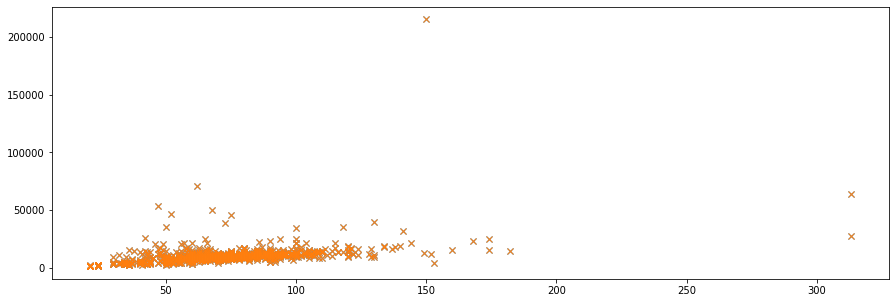

In [123]:
plt.figure(figsize=(15,5))
plt.plot(train['LotFrontage'], train['LotArea'],'x')
plt.plot(train['LotFrontage'], train['LotArea'],'x')

Let's try to predict the missing values of LotFrontage by a Linear Regression.

In [117]:
lr = LinearRegression()
#lotfrontage_true = train['LotFrontage'].isnull != None
#pd_lotfrontage_true = train[lotfrontage_true]
#lotfrontage_true

lotfrontage_true = pd.isna(train['LotFrontage']) == False
df_lotfrontage_true = train[lotfrontage_true]

x = df_lotfrontage_true['LotFrontage'].values.reshape(-1, 1)
y = df_lotfrontage_true[['LotArea']].values

x
lr.fit(x,y)
lr.score(x, y)


0.18155696502214747

In [ ]:
We can see from the R2 score that the two variables are actually very poorly correlated. We will drop this feature for a first analysis.
Let us now clean the data.

## Data cleaning

Let's first drop the row with the 1 missing value for the Electrical feature:

In [124]:
electrical_true = pd.isna(train['Electrical']) == False
train = train[electrical_true]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Converting Categorical Features
We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1200 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [126]:
obj_df = train.select_dtypes(include=['object']).copy()
obj_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


Let's convert the binary categorical variables to dummy variables

In [128]:
pd.get_dummies(train, columns=["Street", "CentralAir"]).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Street_Grvl,Street_Pave,CentralAir_N,CentralAir_Y
0,1,60,RL,65.0,8450,NaN,Reg,Lvl,AllPub,Inside,...,0,2,2008,WD,Normal,208500,0,1,0,1
1,2,20,RL,80.0,9600,NaN,Reg,Lvl,AllPub,FR2,...,0,5,2007,WD,Normal,181500,0,1,0,1
2,3,60,RL,68.0,11250,NaN,IR1,Lvl,AllPub,Inside,...,0,9,2008,WD,Normal,223500,0,1,0,1
3,4,70,RL,60.0,9550,NaN,IR1,Lvl,AllPub,Corner,...,0,2,2006,WD,Abnorml,140000,0,1,0,1
4,5,60,RL,84.0,14260,NaN,IR1,Lvl,AllPub,FR2,...,0,12,2008,WD,Normal,250000,0,1,0,1


Let's separate the categorical variables into two sub_groups: the nominal and the ordinal ones.

In [129]:
#algorithm to choose the best set of features 
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
           k_features=11,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)

sfs.fit(X, y)
sfs.k_feature_names_     # to get the final set of features



#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
#import matplotlib.pyplot as plt
#fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
#plt.title('Sequential Forward Selection (w. StdErr)')
#plt.grid()
#plt.show()

#the performance label indicates the R-squared values for the different numbers of features.

NameError: name 'SFS' is not defined